Import thư viện

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

Khởi tạo

In [3]:
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True 

DATASET_PATH = "../Dataset"

Tính toán mean, std

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = ImageFolder(root=os.path.join(DATASET_PATH, "Train"), transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=4)

mean = torch.zeros(3)
std = torch.zeros(3)
num_batches = 0

for batch, _ in train_loader:
    mean += batch.mean(dim=(0, 2, 3))
    std += batch.std(dim=(0, 2, 3))
    num_batches += 1

mean /= num_batches
std /= num_batches

print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

Chuẩn hóa tập train, val, test

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15, fill=(0,)),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4668, 0.3816, 0.3414], std=[0.2824, 0.2580, 0.2553])
])

test_transforms = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4668, 0.3816, 0.3414], std=[0.2824, 0.2580, 0.2553])
])

In [5]:
train_data = ImageFolder(
    root=os.path.join(DATASET_PATH, "Train"),
    transform=train_transforms)

val_data = ImageFolder(
    root=os.path.join(DATASET_PATH, "Validation"),
    transform=test_transforms)

test_data = ImageFolder(
    root=os.path.join(DATASET_PATH, "Test"),
    transform=test_transforms)

In [6]:
BATCH_SIZE = 64

train_iterator = DataLoader(train_data,
                            shuffle=True,
                            batch_size=BATCH_SIZE,
                            num_workers=4)

val_iterator = DataLoader(val_data,
                          batch_size=BATCH_SIZE,
                          num_workers=4)

test_iterator = DataLoader(test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=4)


Model Define 


In [7]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(ImprovedCNN, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        # Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)
        
        # 28x28 -> 14x14 -> 7x7 -> 3x3 (after 3 max pooling layers)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

Khởi tạo thiết bị, model, hàm loss, optimizer, lr

In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

d:\pro2\AI_ComputerVision_Project\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_params(model)}")

Total trainable parameters: 584098


Train & Val

In [8]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
best_model_path = os.path.join(save_dir, "best_cnn_model.pth")

# Training loop
num_epochs = 15
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    train_iterator_tqdm = tqdm(train_iterator, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, labels in train_iterator_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / total_train
    train_acc = 100.0 * correct_train / total_train
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_iterator:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    
    val_loss /= total_val
    val_acc = 100.0 * correct_val / total_val
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Cập nhật learning rate dựa trên validation loss
    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Lưu mô hình nếu có val acc tốt hơn
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"--> Saved best model with Val Acc: {best_val_acc:.2f}%")

print("Training complete! Best Val Acc: {:.2f}%".format(best_val_acc))

Epoch 1/15: 100%|██████████| 2188/2188 [11:12<00:00,  3.26it/s]


Epoch [1/15] | Train Loss: 0.5369, Train Acc: 72.14% | Val Loss: 0.5803, Val Acc: 70.31%
--> Saved best model with Val Acc: 70.31%


Epoch 2/15: 100%|██████████| 2188/2188 [08:57<00:00,  4.07it/s]


Epoch [2/15] | Train Loss: 0.4627, Train Acc: 77.54% | Val Loss: 0.5923, Val Acc: 70.73%
--> Saved best model with Val Acc: 70.73%


Epoch 3/15: 100%|██████████| 2188/2188 [07:43<00:00,  4.73it/s]


Epoch [3/15] | Train Loss: 0.4340, Train Acc: 79.34% | Val Loss: 0.5462, Val Acc: 74.40%
--> Saved best model with Val Acc: 74.40%


Epoch 4/15: 100%|██████████| 2188/2188 [08:13<00:00,  4.43it/s]


Epoch [4/15] | Train Loss: 0.4132, Train Acc: 80.58% | Val Loss: 0.4538, Val Acc: 78.01%
--> Saved best model with Val Acc: 78.01%


Epoch 5/15: 100%|██████████| 2188/2188 [06:16<00:00,  5.82it/s]


Epoch [5/15] | Train Loss: 0.3994, Train Acc: 81.30% | Val Loss: 0.4309, Val Acc: 81.21%
--> Saved best model with Val Acc: 81.21%


Epoch 6/15: 100%|██████████| 2188/2188 [04:55<00:00,  7.41it/s]


Epoch [6/15] | Train Loss: 0.3865, Train Acc: 82.08% | Val Loss: 0.4470, Val Acc: 79.88%


Epoch 7/15: 100%|██████████| 2188/2188 [05:05<00:00,  7.17it/s]


Epoch [7/15] | Train Loss: 0.3783, Train Acc: 82.63% | Val Loss: 0.3474, Val Acc: 84.47%
--> Saved best model with Val Acc: 84.47%


Epoch 8/15: 100%|██████████| 2188/2188 [05:07<00:00,  7.13it/s]


Epoch [8/15] | Train Loss: 0.3734, Train Acc: 82.88% | Val Loss: 0.4053, Val Acc: 82.89%


Epoch 9/15: 100%|██████████| 2188/2188 [04:56<00:00,  7.37it/s]


Epoch [9/15] | Train Loss: 0.3654, Train Acc: 83.35% | Val Loss: 0.4268, Val Acc: 81.55%


Epoch 10/15: 100%|██████████| 2188/2188 [06:42<00:00,  5.44it/s]


Epoch [10/15] | Train Loss: 0.3604, Train Acc: 83.63% | Val Loss: 0.3931, Val Acc: 82.30%


Epoch 11/15: 100%|██████████| 2188/2188 [06:02<00:00,  6.04it/s]


Epoch [11/15] | Train Loss: 0.3453, Train Acc: 84.44% | Val Loss: 0.3742, Val Acc: 83.13%


Epoch 12/15: 100%|██████████| 2188/2188 [04:42<00:00,  7.74it/s]


Epoch [12/15] | Train Loss: 0.3386, Train Acc: 84.82% | Val Loss: 0.4504, Val Acc: 81.09%


Epoch 13/15: 100%|██████████| 2188/2188 [05:03<00:00,  7.20it/s]


Epoch [13/15] | Train Loss: 0.3350, Train Acc: 84.95% | Val Loss: 0.3331, Val Acc: 85.27%
--> Saved best model with Val Acc: 85.27%


Epoch 14/15: 100%|██████████| 2188/2188 [04:55<00:00,  7.41it/s]


Epoch [14/15] | Train Loss: 0.3317, Train Acc: 85.10% | Val Loss: 0.3619, Val Acc: 84.29%


Epoch 15/15: 100%|██████████| 2188/2188 [04:49<00:00,  7.56it/s]


Epoch [15/15] | Train Loss: 0.3288, Train Acc: 85.32% | Val Loss: 0.3689, Val Acc: 83.64%
Training complete! Best Val Acc: 85.27%


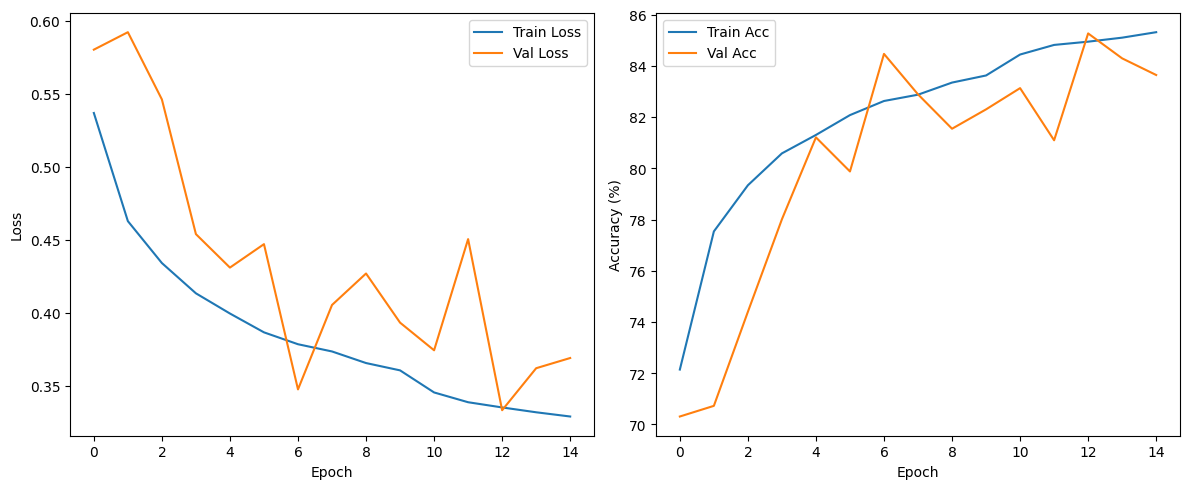

In [ ]:
# Vẽ biểu đồ loss và accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('CNN_training_history.png')
plt.show()


In [10]:
model.load_state_dict(torch.load(best_model_path))
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_iterator:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

test_acc = 100.0 * correct_test / total_test
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 84.15%
